In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from models.networks.Attention_unet import *
from datasets.cd_dataset import SequenceDataset
from transforms.augmentations import *
import glob
import os
from torch.utils.data import DataLoader
import json
from train.loss_functions import DiceLoss


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open('logs/training_history_attention_unet.json', 'r') as f:
    history = json.load(f)

In [4]:
# Extract data
train_loss = history['train_loss']
val_loss = history['val_loss']
train_dice = history.get('train_dice', [])
val_dice = history.get('val_dice', [])

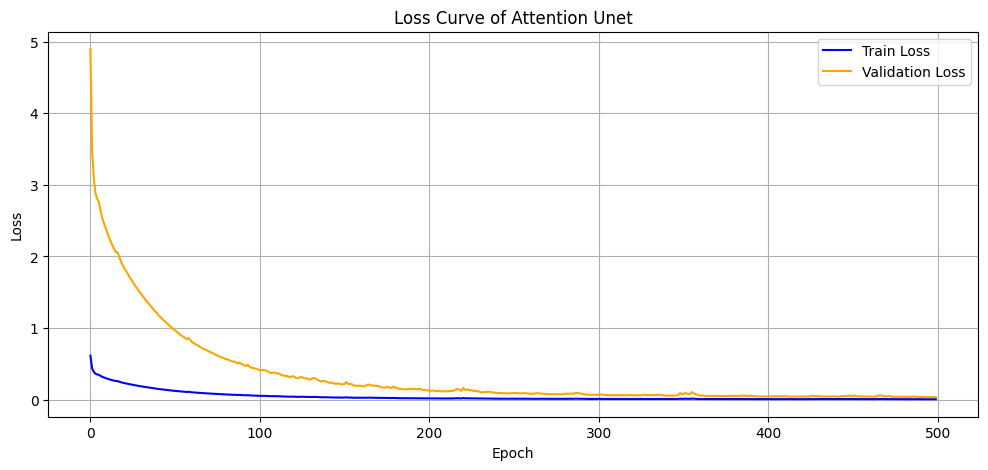

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve of Attention Unet')
plt.legend()
plt.grid(True)

In [6]:
with open('splits/splits.json', 'r') as f:
    splits = json.load(f)

train_images = splits['train']['images']
train_labels = splits['train']['labels']

val_images = splits['val']['images']
val_labels = splits['val']['labels']

test_images = splits['test']['images']
test_labels = splits['test']['labels']

In [7]:
transform=Compose3D([RandomFlip3D(axes=(0,1,2),p=0.5),
                     AddGaussianNoise3D(mean=0,std=0.03),
                     IntensityShift3D(shift_range=(-0.05,0.05),scale_range=(0.95,1.05)),
                     NormalizeTo01()])

transform_val=Compose3D([NormalizeTo01()])

transform_test=Compose3D([NormalizeTo01()])

In [8]:
test_dataset = SequenceDataset(test_images, test_labels, crop=True,target_size=(256,256),limit_sequence=True,transform=transform_test,allowed_length=45)
loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [13]:
images_1, labels_1 = next(iter(loader))

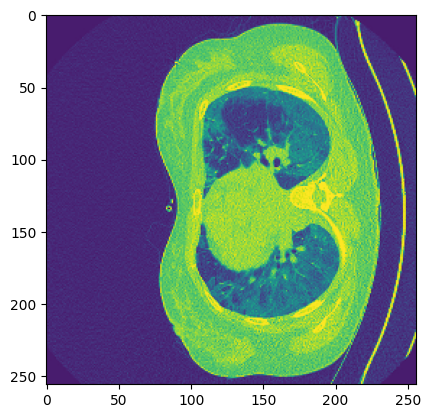

In [16]:
plt.imshow(images_1[0,0,:,:,-1])

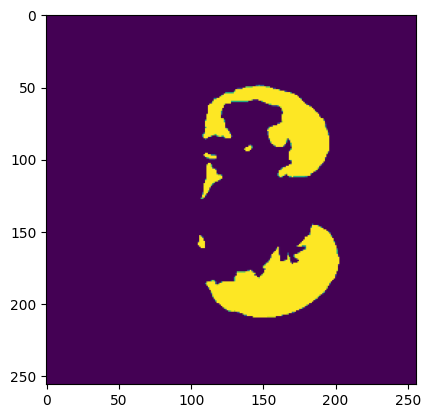

In [15]:
plt.imshow(labels_1[0,0,:,:,-1])

In [17]:
images_1=images_1.to(device)
labels_1=labels_1.to(device)

In [18]:
model = AttentionUnet(n_classes=1, in_channels=1).to(device)
checkpoints_path='/home/jaworskj/Desktop/Foundaition_thermography/Attention_unet/checkpoints/model_unet_epoch_500.pth'
model.load_state_dict(torch.load(checkpoints_path,map_location=device))
model.eval()

AttentionUnet(
  (convdown1): DownBlock(
    (convblock): ConvBlock(
      (block): Sequential(
        (0): Conv3d(1, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (convdown2): DownBlock(
    (convblock): ConvBlock(
      (block): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(128, 128, kernel_size=(3, 3, 1), stride

In [19]:
# Forward pass
with torch.no_grad():  # no need to track gradients for testing
    output, att4, att3, att2 = model(images_1)

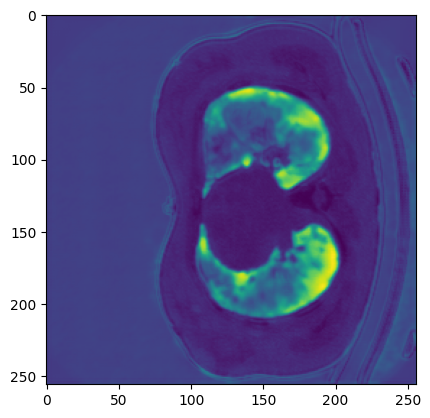

In [20]:
output=output.to(device='cpu')
plt.imshow(output[0,0,:,:,-1])

In [30]:
binary_output=(torch.sigmoid(output)>0.003).float()

In [32]:
labels_1=labels_1.to(device='cpu')

Text(0.5, 1.0, 'Ground truth')

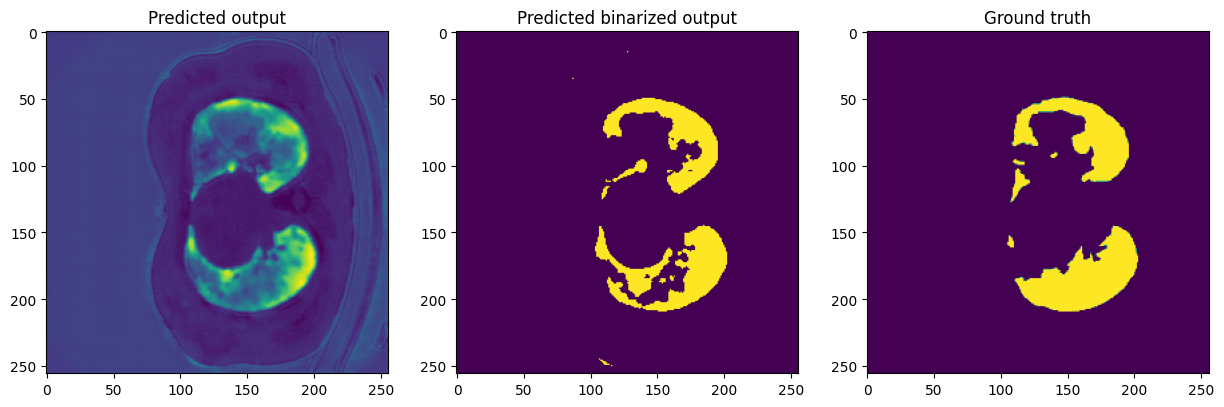

In [33]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(output[0,0,:,:,-1])
plt.title('Predicted output')
plt.subplot(1,3,2)
plt.imshow(binary_output[0,0,:,:,-1])
plt.title('Predicted binarized output')
plt.subplot(1,3,3)
plt.imshow(labels_1[0,0,:,:,-1])
plt.title('Ground truth')



Text(0.5, 1.0, 'Ground truth')

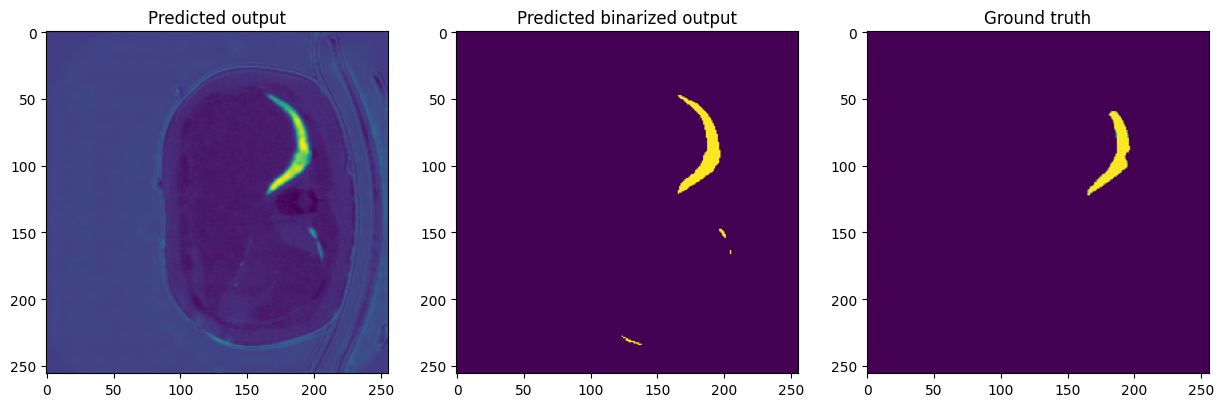

In [39]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(output[0,0,:,:,15])
plt.title('Predicted output')
plt.subplot(1,3,2)
plt.imshow(binary_output[0,0,:,:,15])
plt.title('Predicted binarized output')
plt.subplot(1,3,3)
plt.imshow(labels_1[0,0,:,:,15])
plt.title('Ground truth')

In [35]:
att2=att2.to(device='cpu')
att3=att3.to(device='cpu')
att4=att4.to(device='cpu')

Text(0.5, 1.0, 'Deepest attention map')

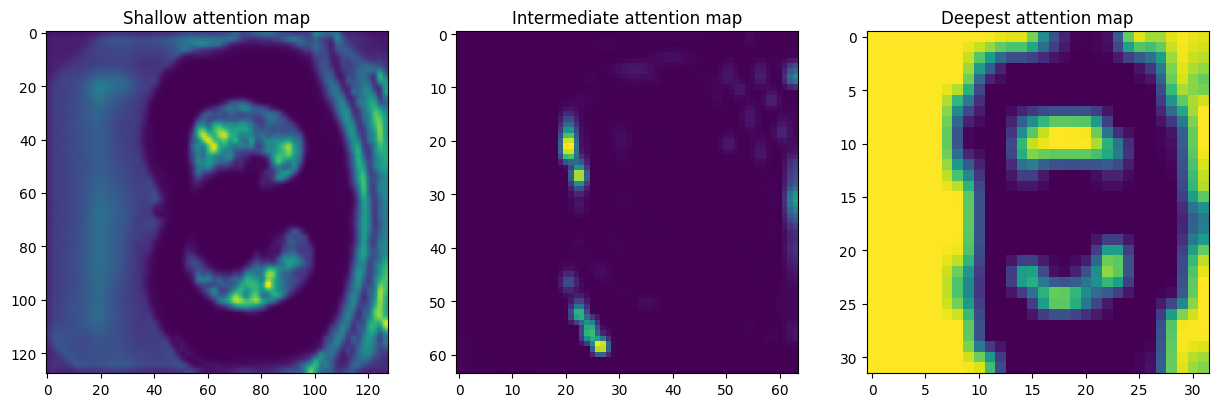

In [37]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(att2[0,0,:,:,-1])
plt.title('Shallow attention map')
plt.subplot(1,3,2)
plt.imshow(att3[0,0,:,:,-1])
plt.title('Intermediate attention map')
plt.subplot(1,3,3)
plt.imshow(att4[0,0,:,:,-1])
plt.title('Deepest attention map')

Text(0.5, 1.0, 'Deepest attention map')

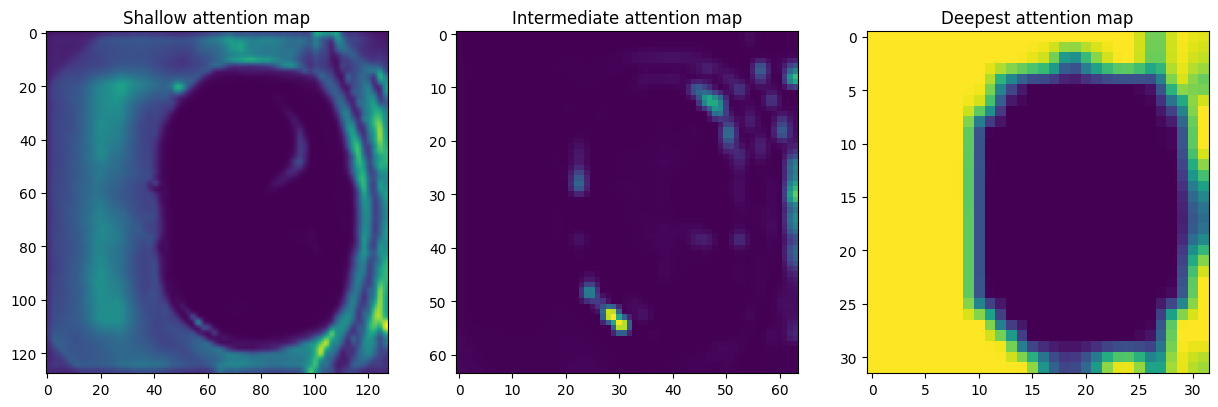

In [38]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(att2[0,0,:,:,15])
plt.title('Shallow attention map')
plt.subplot(1,3,2)
plt.imshow(att3[0,0,:,:,15])
plt.title('Intermediate attention map')
plt.subplot(1,3,3)
plt.imshow(att4[0,0,:,:,15])
plt.title('Deepest attention map')